In [1]:
import numpy as np
from scipy.optimize import minimize
from multiprocessing import Pool
from typing import List, Dict, Tuple, Optional
import yfinance as yf
import pandas as pd
from numpy.random import normal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Optional
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
from typing import Optional
import os
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as pdr

In [140]:
class GlobalEconomy:
    def __init__(
        self,
        gdp: float = 100.0,
        interest_rate: float = 0.05,
        exchange_rate: float = 1.0,
        oil_price: float = 50.0,
        inflation: float = 0.03,
        sanctions: bool = False,
        fred_api_key: Optional[str] = "6ee07609e687d144a9f1ced15728b793",
        start_date: str = "2015-01-01",
        end_date: str = "2023-12-31",
        data_source: str = "yfinance"
    ):
        """
        Класс моделирует состояние глобальной экономики.
        """
        self.gdp = gdp
        self.interest_rate = interest_rate
        self.exchange_rate = exchange_rate
        self.oil_price = oil_price
        self.inflation = inflation
        self.sanctions = sanctions

        self.data_source = data_source
        self.fred_api_key = fred_api_key
        self.start_date = start_date
        self.end_date = end_date

        self.data = pd.DataFrame()
        self.correlation_matrix = np.identity(5)

        # Параметры волатильности
        self.gdp_growth_vol = 0.02
        self.rate_vol = 0.01
        self.exchange_vol = 0.15
        self.oil_price_vol = 0.20
        self.inflation_vol = 0.01

        # Долгосрочные тренды
        self.long_term_gdp_growth = 0.015
        self.inflation_target = 0.04

        self._load_data()

        if not self.data.empty:
            self.correlation_matrix = self.data.corr().values
            print("Корреляционная матрица успешно рассчитана:")
            print(pd.DataFrame(self.correlation_matrix))
        else:
            print("Данные не загружены — используется единичная матрица.")

    def _load_data(self):
        """Загружает финансовые данные из Yahoo Finance и инфляцию из FRED."""
        # Путь к файлам
        data_file = "econ_data.xlsx"
        corr_matrix_file = "econ_corr_matrix.xlsx"
        corr_matrix_npy = "econ_corr.npy"

        # Проверяем, существуют ли уже сохраненные данные
        if os.path.exists(data_file) and os.path.exists(corr_matrix_file) and os.path.exists(corr_matrix_npy):
            print("Загружаем данные из локальных файлов...")
            # Загружаем уже сохраненные данные
            self.data = pd.read_excel(data_file, index_col=0)
            self.correlation_matrix = pd.read_excel(corr_matrix_file, index_col=0).values
        else:
            print("Загружаем данные из источников...")

            # Загрузка данных из Yahoo Finance
            yahoo_tickers = {
                "Oil_WTI": "CL=F",
                "US10Y_Yield": "^TNX",
                "S&P500": "^GSPC",
                "Dollar_Index": "DX-Y.NYB",
                "Gold": "GC=F"
            }

            frames = []
            for name, ticker in yahoo_tickers.items():
                df = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False, auto_adjust=True)
                if not df.empty:
                    series = df["Close"]
                    series.name = name
                    frames.append(series)

            yahoo_data = pd.concat(frames, axis=1)
            yahoo_monthly = yahoo_data.resample("ME").last()  # Используем 'ME', как рекомендовано

            # Загрузка инфляции из FRED
            cpi = pdr.DataReader("CPIAUCSL", "fred", start=self.start_date, end=self.end_date, api_key=self.fred_api_key)
            cpi = cpi.resample("ME").last()  # Также используем 'ME'
            inflation = cpi["CPIAUCSL"].pct_change() * 100
            inflation.name = "Inflation_MoM%"

            # Объединение данных
            self.data = pd.concat([yahoo_monthly, inflation], axis=1).dropna()
            self.correlation_matrix = self.data.corr().values

            # Сохраняем в файлы для будущего использования
            self.data.to_excel(data_file)
            pd.DataFrame(self.correlation_matrix).to_excel(corr_matrix_file)
            np.save(corr_matrix_npy, self.correlation_matrix)

            print("Данные успешно сохранены!")

    def save_data(self):
        """Сохранение данных и корреляций в файлы."""
        if self.data.empty:
            print("Данные не были загружены, сохранить невозможно.")
            return

        # Сохраняем данные в Excel
        self.data.to_excel("econ_data.xlsx")

        # Сохраняем корреляционную матрицу в Excel и numpy
        pd.DataFrame(self.correlation_matrix).to_excel("econ_corr_matrix.xlsx")
        np.save("econ_corr.npy", self.correlation_matrix)
        print("Данные успешно сохранены!")

    def evolve(self, external_shock: Optional[str] = None):
        """Имитация изменений экономики за один временной шаг."""
        np.random.seed()

        if external_shock == "oil_crisis":
            self.oil_price *= 0.7
            self.gdp *= 0.95
            self.inflation += 0.01
        elif external_shock == "financial_crisis":
            self.gdp *= 0.9
            self.interest_rate = max(0, self.interest_rate - 0.02)
            self.inflation = max(0, self.inflation - 0.01)
        elif external_shock == "rate_hike":
            self.interest_rate = min(1.0, self.interest_rate + 0.03)
            self.inflation *= 0.9
            self.gdp *= 0.98
        elif external_shock == "sanctions":
            self.sanctions = True
            self.exchange_vol *= 2
            self.exchange_rate *= 1.1
        else:
            mean = [0, 0, 0, 0, 0]
            cov = self._get_covariance_matrix()
            shocks = np.random.multivariate_normal(mean, cov)

            self._update_gdp(shocks[0])
            self._update_interest_rate(shocks[1])
            self._update_exchange_rate(shocks[2])
            self._update_oil_price(shocks[3])
            self._update_inflation(shocks[4])

    def _get_covariance_matrix(self) -> np.ndarray:
        """
        Собираем ковариационную матрицу для модели из stds и
        подматрицы self.correlation_matrix нужного размера.
        """
        # 1) Вектор стандартных отклонений для пяти шоков
        stds = np.array([
            self.gdp_growth_vol,
            self.rate_vol,
            self.exchange_vol,
            self.oil_price_vol,
            self.inflation_vol
        ])  # length == 5

        # 2) Если correlation_matrix > 5×5, обрезаем
        corr = self.correlation_matrix
        if corr.shape[0] > len(stds):
            corr = corr[:len(stds), :len(stds)]

        # 3) Возвращаем скорректированную ковариационную матрицу
        return corr * np.outer(stds, stds)


    def _update_gdp(self, shock: float):
        gdp_growth = self.long_term_gdp_growth + shock
        self.gdp *= np.exp(gdp_growth)

    def _update_interest_rate(self, shock: float):
        inflation_impact = max(0, self.inflation - self.inflation_target)
        self.interest_rate += 0.01 * (self.gdp / 100) + inflation_impact + shock
        self.interest_rate = np.clip(self.interest_rate, 0.01, 0.5)

    def _update_exchange_rate(self, shock: float):
        rate_effect = 0.5 * (self.interest_rate - 0.05)
        sanctions_effect = -0.1 if self.sanctions else 0
        self.exchange_rate *= np.exp(rate_effect + sanctions_effect + shock)

    def _update_oil_price(self, shock: float):
        oil_shock = np.random.normal(0, self.oil_price_vol)
        self.oil_price *= np.exp(oil_shock)
        self.oil_price = max(20.0, self.oil_price)

    def _update_inflation(self, shock: float):
        inflation_change = 0.1 * (self.interest_rate - self.inflation_target) + shock
        self.inflation = np.clip(self.inflation + inflation_change, 0.01, 0.5)

    def calculate_var(self, confidence_level: float = 0.95) -> float:
        """Расчет Value at Risk (VaR) для цены на нефть."""
        returns = np.random.normal(self.oil_price, self.oil_price_vol, 10000)
        var = np.percentile(returns, (1 - confidence_level) * 100)
        return var

    def __repr__(self):
        return (f"GlobalEconomy(GDP={self.gdp:.2f}, InterestRate={self.interest_rate:.2%}, "
                f"ExchangeRate={self.exchange_rate:.2f}, OilPrice={self.oil_price:.2f}, "
                f"Inflation={self.inflation:.2%}, Sanctions={self.sanctions})")

In [13]:
# Создаем объект класса GlobalEconomy без необходимости передавать API ключ и даты
global_economy = GlobalEconomy()

# Печатаем текущие данные для проверки
print(global_economy.data.head())

# Проверяем корреляционную матрицу
print("Корреляционная матрица:")
print(global_economy.correlation_matrix)

# Моделируем изменение экономики (например, экономический шок)
global_economy.evolve(external_shock="oil_crisis")

# Печатаем обновленные данные
print("После шока:")
print(global_economy)

# Сохраняем данные в файлы
global_economy.save_data()

Загружаем данные из локальных файлов...
Корреляционная матрица успешно рассчитана:
          0         1         2         3         4         5
0  1.000000  0.597571  0.696832  0.403907  0.491638  0.587401
1  0.597571  1.000000  0.251093  0.617877  0.091992  0.038082
2  0.696832  0.251093  1.000000  0.253390  0.909906  0.503855
3  0.403907  0.617877  0.253390  1.000000  0.247926 -0.059044
4  0.491638  0.091992  0.909906  0.247926  1.000000  0.396006
5  0.587401  0.038082  0.503855 -0.059044  0.396006  1.000000
                 CL=F   ^TNX        ^GSPC   DX-Y.NYB         GC=F  \
2015-02-28  49.759998  2.002  2104.500000  95.250000  1212.599976   
2015-03-31  47.599998  1.934  2067.889893  98.360001  1183.099976   
2015-04-30  59.630001  2.046  2085.510010  94.599998  1182.400024   
2015-05-31  60.299999  2.095  2107.389893  96.910004  1189.400024   
2015-06-30  59.470001  2.335  2063.110107  95.489998  1171.500000   

            Inflation_MoM%  
2015-02-28        0.253464  
2015-03-31

In [198]:
class CompanyEconomy:
    def __init__(
        self,
        debt: Optional[float] = 0.0,
        amortization_type: str = 'linear',  # 'linear' или 'annuity'
        accumulated_loss: float = 0.0,
        loan_term: int = 5,  # срок кредита
        global_economy: Optional['GlobalEconomy'] = None,  # глобальная экономика
        dividend_percentage: float = 0.1  # Процент от чистой прибыли или свободного денежного потока
    ):
        self.debt = debt
        self.amortization_type = amortization_type
        self.accumulated_loss = accumulated_loss
        self.loan_term = loan_term
        self.global_economy = global_economy
        self.operating_cost = 10.0  # базовые издержки
        self.tax_rate = 0.25  # фиксированная налоговая ставка
        self.dividend_percentage = dividend_percentage  # процент для расчета дивидендов

    def calculate_amortization(self) -> float:
        """Расчет амортизации по долгу"""
        if self.amortization_type == 'linear':
            return self.debt / self.loan_term
        elif self.amortization_type == 'annuity':
            r = self.global_economy.interest_rate if self.global_economy else 0.10
            n = self.loan_term
            return self.debt * (r * (1 + r) ** n) / ((1 + r) ** n - 1)
        else:
            raise ValueError("Неверный тип амортизации. Выберите 'linear' или 'annuity'.")

    def calculate_financials(self, cash_flow: float) -> dict:
        """Расчет чистой прибыли и свободного денежного потока"""
        # Получаем данные из глобальной экономики (например, процентную ставку и инфляцию)
        interest_rate = self.global_economy.interest_rate if self.global_economy else 0.05
        inflation = self.global_economy.inflation if self.global_economy else 0.03

        # Пересчитываем операционные расходы с учетом инфляции
        adjusted_operating_cost = self.operating_cost * (1 + inflation)
        ebitda = cash_flow - adjusted_operating_cost

        # Пересчитываем Interest Expense в зависимости от нового долга
        interest_expense = self.debt * interest_rate  # Теперь учитывается новый долг

        # Расчет налогооблагаемого дохода (без учета убытков и амортизации)
        taxable_income = ebitda - interest_expense - self.accumulated_loss
        taxable_income = max(0, taxable_income)  # Налогооблагаемый доход не может быть отрицательным

        # Расчет налога и чистой прибыли
        tax = taxable_income * self.tax_rate
        net_income = taxable_income - tax

        # Обновляем накопленные убытки
        self.accumulated_loss = max(0, self.accumulated_loss + taxable_income - ebitda)

        # Расчет свободного денежного потока
        free_cash_flow = net_income + self.calculate_amortization()

        # Возвращаем финансовые показатели
        return {
            'EBITDA': ebitda,
            'Net Income': net_income,
            'Free Cash Flow': free_cash_flow,
            'Interest Expense': interest_expense
        }

    def take_loan(self, amount: float):
        """Взять новый кредит и увеличить долг"""
        if amount <= 0:
            raise ValueError("Сумма кредита должна быть положительной")
        self.debt += amount
        print(f"Новый долг после получения кредита: {self.debt:.2f}")

    def pay_dividends(self, cash_flow: float = None):
        """Выплата дивидендов как процент от свободного денежного потока"""
        if cash_flow is None:
            # Если cash_flow не передан, можем использовать свободный денежный поток как расчетный
            financials = self.calculate_financials(cash_flow=self.debt * 0.2)  # Пример расчета, основанный на долге
        else:
            financials = self.calculate_financials(cash_flow=cash_flow)

        # Рассчитываем дивиденды как процент от свободного денежного потока
        dividends = financials['Free Cash Flow'] * self.dividend_percentage

        # Проверяем, хватает ли средств для выплаты дивидендов
        if financials['Net Income'] < dividends:
            raise ValueError(f"Недостаточно средств для выплаты дивидендов. Доступно: {financials['Net Income']:.2f}, требуемо: {dividends:.2f}")

        print(f"Выплачено дивидендов: {dividends:.2f}")

In [39]:
# Создаем объект GlobalEconomy (глобальной экономики)
global_economy = GlobalEconomy(
    gdp=100.0,
    interest_rate=0.05,  # процентная ставка
    exchange_rate=1.0,
    oil_price=50.0,
    inflation=0.03,  # инфляция
    sanctions=False
)

# Создаем объект CompanyEconomy (экономики компании), передавая ссылку на глобальную экономику
company_economy = CompanyEconomy(
    debt=100000,  # долг компании
    amortization_type='linear',  # линейная амортизация
    loan_term=5,  # срок кредита
    global_economy=global_economy,  # связь с глобальной экономикой
    dividend_percentage=0.05  # 5% от свободного денежного потока для дивидендов
)

# Рассчитываем амортизацию
amortization = company_economy.calculate_amortization()
print(f"Амортизация: {amortization:.2f}")

# Рассчитываем финансовые показатели компании с денежным потоком
financials = company_economy.calculate_financials(cash_flow=100000)  # например, реальный денежный поток компании
print("Финансовые показатели компании:")
print(financials)

# Взять новый кредит
company_economy.take_loan(amount=50000)

# Выплатить дивиденды
company_economy.pay_dividends(cash_flow=100000)  # Дивиденды как процент от свободного денежного потока

Загружаем данные из локальных файлов...
Корреляционная матрица успешно рассчитана:
          0         1         2         3         4         5
0  1.000000  0.597571  0.696832  0.403907  0.491638  0.587401
1  0.597571  1.000000  0.251093  0.617877  0.091992  0.038082
2  0.696832  0.251093  1.000000  0.253390  0.909906  0.503855
3  0.403907  0.617877  0.253390  1.000000  0.247926 -0.059044
4  0.491638  0.091992  0.909906  0.247926  1.000000  0.396006
5  0.587401  0.038082  0.503855 -0.059044  0.396006  1.000000
Амортизация: 20000.00
Финансовые показатели компании:
{'EBITDA': 99989.7, 'Net Income': 75991.76, 'Free Cash Flow': 95991.76, 'Interest Expense': 5000.0}
Новый долг после получения кредита: 150000.00
Выплачено дивидендов: 5199.59


In [154]:
class Action:
    """
    Действие: распределение инвестируемых средств и сумма для погашения долга.
    """
    def __init__(self, allocation, debt_repayment: float = 0.0):
        arr = np.array(allocation, dtype=float)
        if arr.ndim != 1:
            raise ValueError("allocation должен быть одномерным массивом (вектором).")
        if np.any(arr < 0):
            raise ValueError("Все значения в allocation должны быть неотрицательными.")
        if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
            raise ValueError("allocation содержит некорректные значения (NaN или Inf).")
        if debt_repayment < 0:
            raise ValueError("Сумма погашения долга не может быть отрицательной.")
        self.allocation = arr
        self.debt_repayment = float(debt_repayment)

    def __repr__(self):
        return f"Action(allocation={self.allocation}, debt_repayment={self.debt_repayment})"


class State:
    """
    Экономическое состояние: бюджет, рынок, глобальная экономика и экономика компании.
    """
    ALLOWED_MARKET_CONDITIONS = ("bad", "neutral", "good")

    def __init__(self, budget: float, market_condition: str,
                 global_econ: 'GlobalEconomy', company_econ: 'CompanyEconomy'):
        if budget < 0:
            raise ValueError("Бюджет не может быть отрицательным.")
        if market_condition not in State.ALLOWED_MARKET_CONDITIONS:
            raise ValueError(f"market_condition должен быть одним из {State.ALLOWED_MARKET_CONDITIONS}.")
        if not isinstance(global_econ, GlobalEconomy):
            raise TypeError("global_econ должен быть экземпляром GlobalEconomy.")
        if not isinstance(company_econ, CompanyEconomy):
            raise TypeError("company_econ должен быть экземпляром CompanyEconomy.")

        self.budget = float(budget)
        self.market_condition = market_condition
        self.global_econ = global_econ
        self.company_econ = company_econ

    def apply_action(self, action: Action) -> 'State':
        """
        Применяет действие:
          1) сначала гасит долг (до min(company.debt, debt_repayment)),
          2) затем инвестирует остаток бюджета по allocation,
          3) перерасчитывает глобальную экономику,
          4) обновляет долг и считает возврат от инвестиций,
          5) создаёт новый CompanyEconomy и новый State.
        """
        if not isinstance(action, Action):
            raise TypeError("apply_action ожидает объект Action.")

        # Разбиваем действие
        allocation = action.allocation
        debt_repayment = action.debt_repayment

        # 1) Погашаем долг
        repay_amount = min(self.company_econ.debt, debt_repayment)
        budget_after_repay = self.budget - repay_amount
        if budget_after_repay < 0:
            raise ValueError("Недостаточно бюджета для погашения долга.")

        # 2) Инвестируем остаток
        if allocation.sum() <= 1.0:
            invested_amounts = budget_after_repay * allocation
        else:
            invested_amounts = allocation.astype(float)
        invested_total = float(invested_amounts.sum())
        if invested_total > budget_after_repay:
            raise ValueError("Недостаточно остатка бюджета для инвестиций после погашения долга.")

        # 3) Макроэволюция
        self.global_econ.evolve()

        # 4) Новый долг
        new_debt = self.company_econ.debt - repay_amount

        # 5) Рассчитываем возврат от инвестиций
        factor_map = {"good": 1.1, "neutral": 1.0, "bad": 0.9}
        return_factor = factor_map[self.market_condition] - self.global_econ.inflation
        return_factor = max(return_factor, 0.0)
        investment_return = invested_total * return_factor

        # 6) Создаём новый CompanyEconomy с обновлённым долгом
        new_company = CompanyEconomy(
            debt=new_debt,
            amortization_type=self.company_econ.amortization_type,
            accumulated_loss=self.company_econ.accumulated_loss,
            loan_term=self.company_econ.loan_term,
            global_economy=self.global_econ,
            dividend_percentage=self.company_econ.dividend_percentage
        )

        # 7) Считаем свободный денежный поток от возврата инвестиций
        fin = new_company.calculate_financials(cash_flow=investment_return)
        free_cash_flow = fin['Free Cash Flow']

        # 8) Новый бюджет: остаток после погашения и инвестиций + free_cash_flow
        new_budget = budget_after_repay - invested_total + free_cash_flow
        new_budget = max(new_budget, 0.0)

        # 9) Возвращаем новое состояние
        return State(new_budget, self.market_condition, self.global_econ, new_company)



    def apply_shock(self, shock_type: str):
        self.global_econ.evolve(external_shock=shock_type)
        if shock_type in ("oil_crisis", "financial_crisis"):
            self.market_condition = "bad"
        elif shock_type == "rate_hike":
            self.market_condition = "neutral"

    def __repr__(self):
        return (f"State(budget={self.budget:.2f}, market='{self.market_condition}', "
                f"debt={self.company_econ.debt:.2f}, rate={self.global_econ.interest_rate:.3f})")


In [55]:
# 1. Инициализируем глобальную и корпоративную экономику
global_econ = GlobalEconomy(
    gdp=100.0,
    interest_rate=0.05,
    exchange_rate=1.0,
    oil_price=50.0,
    inflation=0.03,
    sanctions=False
)

company_econ = CompanyEconomy(
    debt=100000,
    amortization_type='linear',
    accumulated_loss=0.0,
    loan_term=5,
    global_economy=global_econ,
    dividend_percentage=0.05
)

# 2. Создаем начальное состояние
state = State(
    budget=300000.0,
    market_condition="neutral",
    global_econ=global_econ,
    company_econ=company_econ
)

print("Начальное состояние:", state)

# 3. Формируем действие: гасим 20k долга, затем инвестируем 30%, 20% и 40% от остатка
action = Action(allocation=[0.3, 0.2, 0.4], debt_repayment=20000.0)
print("Действие:", action)

# 4. Применяем действие
new_state = state.apply_action(action)
print("Новое состояние после apply_action:", new_state)

# 5. Применяем внешний шок, например oil_crisis
state.apply_shock("oil_crisis")
print("Состояние после шока:", state)


Загружаем данные из локальных файлов...
Корреляционная матрица успешно рассчитана:
          0         1         2         3         4         5
0  1.000000  0.597571  0.696832  0.403907  0.491638  0.587401
1  0.597571  1.000000  0.251093  0.617877  0.091992  0.038082
2  0.696832  0.251093  1.000000  0.253390  0.909906  0.503855
3  0.403907  0.617877  0.253390  1.000000  0.247926 -0.059044
4  0.491638  0.091992  0.909906  0.247926  1.000000  0.396006
5  0.587401  0.038082  0.503855 -0.059044  0.396006  1.000000
Начальное состояние: State(budget=300000.00, market='neutral', debt=100000.00, rate=0.050)
Действие: Action(allocation=[0.3 0.2 0.4], debt_repayment=20000.0)
Новое состояние после apply_action: State(budget=236569.03, market='neutral', debt=80000.00, rate=0.067)
Состояние после шока: State(budget=300000.00, market='bad', debt=100000.00, rate=0.067)


In [134]:
class InputData:
    def __init__(
        self,
        projects: pd.DataFrame,  # Таблица проектов с параметрами:
                                 # - "name" (str)
                                 # - "required_investment" (float)
                                 # - "expected_return" (float)
                                 # - "risk_level" (float)
                                 # - "sector" (str)
        initial_state: State,    # Начальное состояние (бюджет, рынок, глобальная экономика, компания)
        periods: int = 5,        # Количество временных периодов (лет)
        market_scenarios: dict = None,  # Сценарии рыночных условий (вероятности шоков)
        discount_rate: float = 0.10     # Ставка дисконтирования
    ):
        self.projects = projects
        self.initial_state = initial_state
        self.periods = periods
        self.market_scenarios = market_scenarios or {
            "oil_crisis": 0.15,
            "financial_crisis": 0.10,
            "rate_hike": 0.20,
            "sanctions": 0.05
        }
        self.discount_rate = discount_rate

In [143]:
from copy import deepcopy


class DynamicProgrammingOptimizer:
    def __init__(self, input_data: InputData):
        self.input_data = input_data
        self.memo = {}  # Кэш для мемоизации состояний

    def optimize(self) -> tuple[float, list[Action]]:
        """Основной метод оптимизации"""
        return self._dp(
            state=self.input_data.initial_state,
            period=0,
            best_actions=[]
        )

    def _dp(self, state: State, period: int, best_actions: list[Action]) -> tuple[float, list[Action]]:
        """Рекурсивная функция динамического программирования"""
        # Базовый случай: конец периода
        if period >= self.input_data.periods:
            return self._calculate_terminal_value(state), best_actions

        # Проверка кэша
        key = (state.budget, state.company_econ.debt, state.market_condition, period)
        if key in self.memo:
            return self.memo[key]

        # Генерация возможных действий
        possible_actions = self._generate_actions(state)

        # Оценка всех действий
        max_value = -np.inf
        best_action_sequence = []
        for action in possible_actions:
            try:
                # Применяем действие
                new_state = state.apply_action(action)

                # Моделируем шоки (по сценариям)
                shock_scenarios = self._apply_shocks(new_state)

                # Рассчитываем ожидаемую полезность
                expected_value = 0
                for shock_type, (prob, shocked_state) in shock_scenarios.items():
                    # Рекурсивный вызов для следующего периода
                    value, actions = self._dp(
                        state=shocked_state,
                        period=period + 1,
                        best_actions=best_actions + [action]
                    )
                    expected_value += prob * value

                # Дисконтирование
                discounted_value = expected_value / (1 + self.input_data.discount_rate)

                if discounted_value > max_value:
                    max_value = discounted_value
                    best_action_sequence = best_actions + [action]

            except ValueError as e:
                # Пропускаем недопустимые действия (например, превышение бюджета)
                continue

        # Кэшируем результат
        self.memo[key] = (max_value, best_action_sequence)
        return max_value, best_action_sequence

    def _generate_actions(self, state: State) -> list[Action]:
        """Генерация допустимых действий на основе доступных проектов"""
        actions = []
        projects = self.input_data.projects

        # Генерация всех возможных комбинаций инвестиций
        for i in range(len(projects)):
            for allocation in self._generate_allocations(projects, state.budget):
                # Погашение долга (если возможно)
                max_repayment = min(state.company_econ.debt, state.budget)
                debt_repayment_options = [0, max_repayment * 0.5, max_repayment]

                for repayment in debt_repayment_options:
                    try:
                        action = Action(
                            allocation=allocation,
                            debt_repayment=repayment
                        )
                        actions.append(action)
                    except ValueError:
                        continue

        return actions

    def _generate_allocations(self, projects: pd.DataFrame, budget: float) -> list[np.ndarray]:
        """Генерация векторов распределения инвестиций по проектам"""
        # Здесь можно использовать методы оптимизации (например, knapsack problem)
        # или генерировать случайные допустимые распределения
        pass

    def _apply_shocks(self, state: State) -> dict[str, tuple[float, State]]:
        """Применение рыночных шоков по сценариям"""
        scenarios = {}
        for shock, prob in self.input_data.market_scenarios.items():
            shocked_state = deepcopy(state)
            shocked_state.apply_shock(shock)
            scenarios[shock] = (prob, shocked_state)
        return scenarios

    def _calculate_terminal_value(self, state: State) -> float:
        """Расчет терминальной стоимости компании"""
        # Упрощенная формула: свободный денежный поток / (ставка дисконтирования - темп роста)
        fcf = state.company_econ.calculate_financials(cash_flow=state.budget)['Free Cash Flow']
        return fcf / (self.input_data.discount_rate - state.global_econ.long_term_gdp_growth)

In [144]:
import numpy as np
import pandas as pd
#from classes import GlobalEconomy, CompanyEconomy, Action, State

# 1. Генерация данных по 5 проектам
projects_data = {
    "name": ["Нефтедобыча", "AI-стартап", "Фармацевтика", "ЖКХ", "Ветроэнергетика"],
    "required_investment": [500_000, 300_000, 700_000, 200_000, 900_000],
    "expected_return": [0.12, 0.18, 0.15, 0.08, 0.20],
    "risk_level": [0.08, 0.15, 0.10, 0.05, 0.20],
    "sector": ["oil", "tech", "pharma", "utilities", "energy"]
}
projects = pd.DataFrame(projects_data)

# 2. Инициализация глобальной экономики
# Исправленная инициализация GlobalEconomy
global_econ = GlobalEconomy()

# 3. Инициализация компании
company_econ = CompanyEconomy(
    debt=200_000,
    amortization_type='annuity',
    loan_term=5,
    global_economy=global_econ,
    dividend_percentage=0.15
)

# 4. Начальное состояние
initial_state = State(
    budget=1_000_000,
    market_condition="neutral",
    global_econ=global_econ,
    company_econ=company_econ
)

# 5. Пример действия (инвестиции + погашение долга)
investment_allocation = np.array([0.4, 0.3, 0.0, 0.2, 0.1])  # 40% в нефть, 30% в AI и т.д.
debt_repayment = 50_000

action = Action(
    allocation=investment_allocation,
    debt_repayment=debt_repayment
)

# 6. Применение действия и эволюция состояния
try:
    new_state = initial_state.apply_action(action)
    print("Состояние после действия:")
    print(new_state)

    # Применяем шок (например, нефтяной кризис)
    new_state.apply_shock("oil_crisis")
    print("\nСостояние после шока:")
    print(new_state)

except ValueError as e:
    print(f"Ошибка: {e}")

# 7. Расчет финансовых показателей
financials = company_econ.calculate_financials(cash_flow=500_000)
print("\nФинансовые показатели:")
print(f"EBITDA: {financials['EBITDA']:.2f}")
print(f"Чистая прибыль: {financials['Net Income']:.2f}")
print(f"Свободный денежный поток: {financials['Free Cash Flow']:.2f}")

Загружаем данные из локальных файлов...
Корреляционная матрица успешно рассчитана:
          0         1         2         3         4         5
0  1.000000  0.597571  0.696832  0.403907  0.491638  0.587401
1  0.597571  1.000000  0.251093  0.617877  0.091992  0.038082
2  0.696832  0.251093  1.000000  0.253390  0.909906  0.503855
3  0.403907  0.617877  0.253390  1.000000  0.247926 -0.059044
4  0.491638  0.091992  0.909906  0.247926  1.000000  0.396006
5  0.587401  0.038082  0.503855 -0.059044  0.396006  1.000000
Состояние после действия:
State(budget=780227.76, market='neutral', debt=150000.00, rate=0.052)

Состояние после шока:
State(budget=780227.76, market='bad', debt=150000.00, rate=0.052)

Финансовые показатели:
EBITDA: 499989.79
Чистая прибыль: 391741.03
Свободный денежный поток: 438136.34


In [ ]:
import numpy as np

# Данные о проекте (вложенные средства, прибыли от инвестиций для каждого проекта)
projects = [
    {"f": [18, 22, 25, 20, 16], "cash_flow": 50},   # 50 тыс. ден. ед.
    {"f": [43, 51, 50, 44, 39], "cash_flow": 100},  # 100 тыс. ден. ед.
    {"f": [57, 60, 61, 64, 55], "cash_flow": 150},  # 150 тыс. ден. ед.
    {"f": [78, 79, 78, 82, 76], "cash_flow": 200},  # 200 тыс. ден. ед.
    {"f": [97, 100, 98, 110, 92], "cash_flow": 250},# 250 тыс. ден. ед.
    {"f": [115, 120, 109, 119, 99], "cash_flow": 300} # 300 тыс. ден. ед.
]

# Максимальная сумма для инвестиций
max_investment = 300

# Функция для динамического программирования
def optimize_investment(projects, max_investment):
    # Массив для хранения максимальных прибылей для каждого возможного остатка средств
    dp = np.zeros(max_investment + 1)
    # Массив для хранения стратегии (сколько средств инвестировать в каждый проект)
    strategy = np.zeros(max_investment + 1, dtype=int)

    # Динамическое программирование для каждого проекта, начиная с последнего
    for k in range(len(projects) - 1, -1, -1):
        cash_flow = projects[k]["cash_flow"]
        f = projects[k]["f"]

        # Для каждого проекта возможны следующие суммы инвестиций: 0, 50, ..., 300 тыс. ден. ед.
        for e in range(max_investment, cash_flow - 1, -50):  # Делаем шаги по 50 тыс. ден. ед.
            for u in range(0, e + 1, 50):  # Распределяем средства по проектам (кратно 50 тыс.)
                potential_profit = f[u // 50] + dp[e - u]
                if potential_profit > dp[e]:
                    dp[e] = potential_profit
                    strategy[e] = u  # Запоминаем стратегию для текущего остатка средств

    # Вернем максимальный доход и стратегию для максимальных средств
    return dp[max_investment], strategy

# Расчет максимальной прибыли и стратегии
result, investment_strategy = optimize_investment(projects, max_investment)

# Вывод результатов
print(f"Максимальный суммарный денежный поток: {result}")

# Вывод стратегии
remaining_budget = max_investment
investment_plan = []
for k in range(len(projects)):
    investment = investment_strategy[remaining_budget]
    investment_plan.append((k + 1, investment))  # Записываем проект и количество инвестиций
    remaining_budget -= investment

print("\nСтратегия распределения инвестиций:")
for project, amount in investment_plan:
    print(f"Проект {project}: {amount} тыс. ден. ед.")

## версия инвестиционной модели от чатки РАБОТАЕТ БЕЗ УЧЕТА Эволюция экономики, Налоги, дивиденды, долговая динамика, Маркетинговые/внешние шоки

In [176]:
class State:
    """
    Экономическое состояние: бюджет, рынок, глобальная экономика и экономика компании.
    """
    ALLOWED_MARKET_CONDITIONS = ("bad", "neutral", "good")

    def __init__(self, budget: float, market_condition: str,
                 global_econ: 'GlobalEconomy', company_econ: 'CompanyEconomy'):
        if budget < 0:
            raise ValueError("Бюджет не может быть отрицательным.")
        if market_condition not in State.ALLOWED_MARKET_CONDITIONS:
            raise ValueError(f"market_condition должен быть одним из {State.ALLOWED_MARKET_CONDITIONS}.")
        if not isinstance(global_econ, GlobalEconomy):
            raise TypeError("global_econ должен быть экземпляром GlobalEconomy.")
        if not isinstance(company_econ, CompanyEconomy):
            raise TypeError("company_econ должен быть экземпляром CompanyEconomy.")

        self.budget = float(budget)
        self.market_condition = market_condition
        self.global_econ = global_econ
        self.company_econ = company_econ

    def apply_action(self, action: Action) -> tuple['State', float]:
        if not isinstance(action, Action):
            raise TypeError("apply_action ожидает объект Action.")

        allocation = action.allocation
        debt_repayment = action.debt_repayment

        repay_amount = min(self.company_econ.debt, debt_repayment)
        budget_after_repay = self.budget - repay_amount
        if budget_after_repay < 0:
            raise ValueError("Недостаточно бюджета для погашения долга.")

        # Инвестируем
        if allocation.sum() <= 1.0:
            invested_amounts = budget_after_repay * allocation
        else:
            invested_amounts = allocation.astype(float)
        invested_total = invested_amounts.sum()
        if invested_total > budget_after_repay:
            raise ValueError("Недостаточно средств для инвестиций.")

        # Эволюция макроэкономики
        self.global_econ.evolve()

        # Новый долг
        new_debt = self.company_econ.debt - repay_amount

        # Возврат инвестиций
        factor_map = {"good": 1.1, "neutral": 1.0, "bad": 0.9}
        return_factor = max(factor_map[self.market_condition] - self.global_econ.inflation, 0.0)
        investment_return = invested_total * return_factor

        # Финансовые показатели
        new_company = CompanyEconomy(
            debt=new_debt,
            amortization_type=self.company_econ.amortization_type,
            accumulated_loss=self.company_econ.accumulated_loss,
            loan_term=self.company_econ.loan_term,
            global_economy=self.global_econ,
            dividend_percentage=self.company_econ.dividend_percentage
        )

        fin = new_company.calculate_financials(cash_flow=investment_return)
        free_cash_flow = fin['Free Cash Flow']
        net_income = fin['Net Income']

        #  КОРРЕКТНО: вычитаем всю инвестицию, возвращаем только прибыль
        new_budget = budget_after_repay - invested_total + free_cash_flow
        new_budget = max(new_budget, 0.0)

        new_state = State(new_budget, self.market_condition, self.global_econ, new_company)
        print(f"[DEBUG] Инвестиции: {invested_total:.2f}, Возврат: {investment_return:.2f}, Финансовые показатели: {fin}")
        return new_state, net_income


In [196]:
import numpy as np
import matplotlib.pyplot as plt

class InvestmentModel:
    def __init__(self, projects, step=50, initial_state=None, shock_sequence=None):
        """
        projects: список проектов. Каждый проект – dict с 'levels' и 'profits'.
        step: дискретизация бюджета (по умолчанию 50).
        initial_state: объект State с начальным бюджетом и экономикой.
        """
        self.projects = projects
        self.step = step
        self.initial_state = initial_state
        self.shock_sequence = shock_sequence or []

    def optimize(self):
        # Исходные параметры
        E0 = self.initial_state.budget
        max_units = int(E0 // self.step)
        N = len(self.projects)

        # Таблицы DP и выбора
        dp = [[0] * (max_units + 1) for _ in range(N + 1)]
        choice = [[0] * (max_units + 1) for _ in range(N)]

        # Заполнение таблицы
        for i in range(N - 1, -1, -1):
            levels = self.projects[i]['levels']
            profits = self.projects[i]['profits']
            for j in range(max_units + 1):
                best_profit = 0
                best_units = 0
                for idx, invest_amount in enumerate(levels):
                    units = int(invest_amount // self.step)
                    if units <= j:
                        profit = profits[idx] + dp[i + 1][j - units]
                        if profit > best_profit:
                            best_profit = profit
                            best_units = units
                dp[i][j] = best_profit
                choice[i][j] = best_units

        # Восстановление стратегии
        max_profit = dp[0][max_units]
        strategy = []
        rem_units = max_units
        for i in range(N):
            invest_units = choice[i][rem_units]
            strategy.append(invest_units * self.step)
            rem_units -= invest_units

        # Симуляция стратегии
        current_state = State(
            budget=self.initial_state.budget,
            market_condition=self.initial_state.market_condition,
            global_econ=self.initial_state.global_econ,
            company_econ=self.initial_state.company_econ
        )

        total_profit = 0
        states = []
        econ_history = []

        for i, invest in enumerate(strategy):
            if current_state.budget == 0:
                break

            allocation = np.zeros(len(self.projects))
            allocation[i] = invest / current_state.budget if current_state.budget > 0 else 0.0

            # Эволюция глобальной экономики
            # Эволюция глобальной экономики с учетом shock_sequence
            if i < len(self.shock_sequence) and self.shock_sequence[i] != "neutral":
                current_state.global_econ.evolve(external_shock=self.shock_sequence[i])
            else:
                current_state.global_econ.evolve()


            # Финансовые показатели по инвестиции
            financials = current_state.company_econ.calculate_financials(cash_flow=invest)
            profit = financials['Net Income']

            action = Action(allocation=allocation, debt_repayment=0.0)
            next_state, profit = current_state.apply_action(action)

            total_profit += profit
            states.append({
                'step': i + 1,
                'invested': invest,
                'profit': total_profit,
                'remaining_budget': next_state.budget
            })

            econ_history.append({
                'step': i + 1,
                'inflation': current_state.global_econ.inflation,
                'interest_rate': current_state.global_econ.interest_rate,
                'oil_price': current_state.global_econ.oil_price,
                'gdp': current_state.global_econ.gdp
            })

            current_state = next_state

        return max_profit, strategy, states, econ_history

    @staticmethod
    def plot_results(states, econ_history, shock_sequence=None):
        steps = [s['step'] for s in states]
        profits = [s['profit'] for s in states]
        budgets = [s['remaining_budget'] for s in states]

        inflation = [e['inflation'] for e in econ_history]
        interest = [e['interest_rate'] for e in econ_history]
        oil = [e['oil_price'] for e in econ_history]
        gdp = [e['gdp'] for e in econ_history]

        fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        plt.style.use("dark_background")

        # Финансовая динамика
        axs[0].plot(steps, profits, marker='o', label="Накопленная прибыль")
        axs[0].plot(steps, budgets, marker='s', label="Оставшийся бюджет")
        axs[0].set_title("Финансовая динамика")
        axs[0].set_ylabel("Значение")
        axs[0].legend()
        axs[0].grid(True)

        # Экономическая динамика
        axs[1].plot(steps, inflation, marker='o', label="Инфляция")
        axs[1].plot(steps, interest, marker='x', label="Процентная ставка")
        axs[1].plot(steps, oil, marker='s', label="Цена нефти")
        axs[1].plot(steps, gdp, marker='^', label="ВВП")
        axs[1].set_title("Экономическая динамика")
        axs[1].set_xlabel("Этап")
        axs[1].set_ylabel("Значение")
        axs[1].legend()
        axs[1].grid(True)

        if shock_sequence:
            for idx, shock in enumerate(shock_sequence):
                if shock != "neutral":
                    axs[1].annotate(
                        text=shock,
                        xy=(steps[idx], oil[idx]),
                        xytext=(0, 15),
                        textcoords="offset points",
                        ha='center',
                        fontsize=8,
                        color='orange',
                        arrowprops=dict(arrowstyle="->", color='orange', lw=1)
                    )


        plt.tight_layout()
        plt.show()

Загружаем данные из локальных файлов...
Корреляционная матрица успешно рассчитана:
          0         1         2         3         4         5
0  1.000000  0.597571  0.696832  0.403907  0.491638  0.587401
1  0.597571  1.000000  0.251093  0.617877  0.091992  0.038082
2  0.696832  0.251093  1.000000  0.253390  0.909906  0.503855
3  0.403907  0.617877  0.253390  1.000000  0.247926 -0.059044
4  0.491638  0.091992  0.909906  0.247926  1.000000  0.396006
5  0.587401  0.038082  0.503855 -0.059044  0.396006  1.000000
Волатильности:
{'oil_price_vol': 0.5, 'exchange_vol': 0.3, 'gdp_growth_vol': 0.05}
[DEBUG] Инвестиции: 0.00, Возврат: 0.00, Финансовые показатели: {'EBITDA': np.float64(-10.417068814752852), 'Net Income': 0.0, 'Free Cash Flow': 0.0, 'Interest Expense': np.float64(0.0)}
[DEBUG] Инвестиции: 100.00, Возврат: 94.60, Финансовые показатели: {'EBITDA': np.float64(84.06003809315719), 'Net Income': np.float64(63.04502856986788), 'Free Cash Flow': np.float64(63.04502856986788), 'Interest 

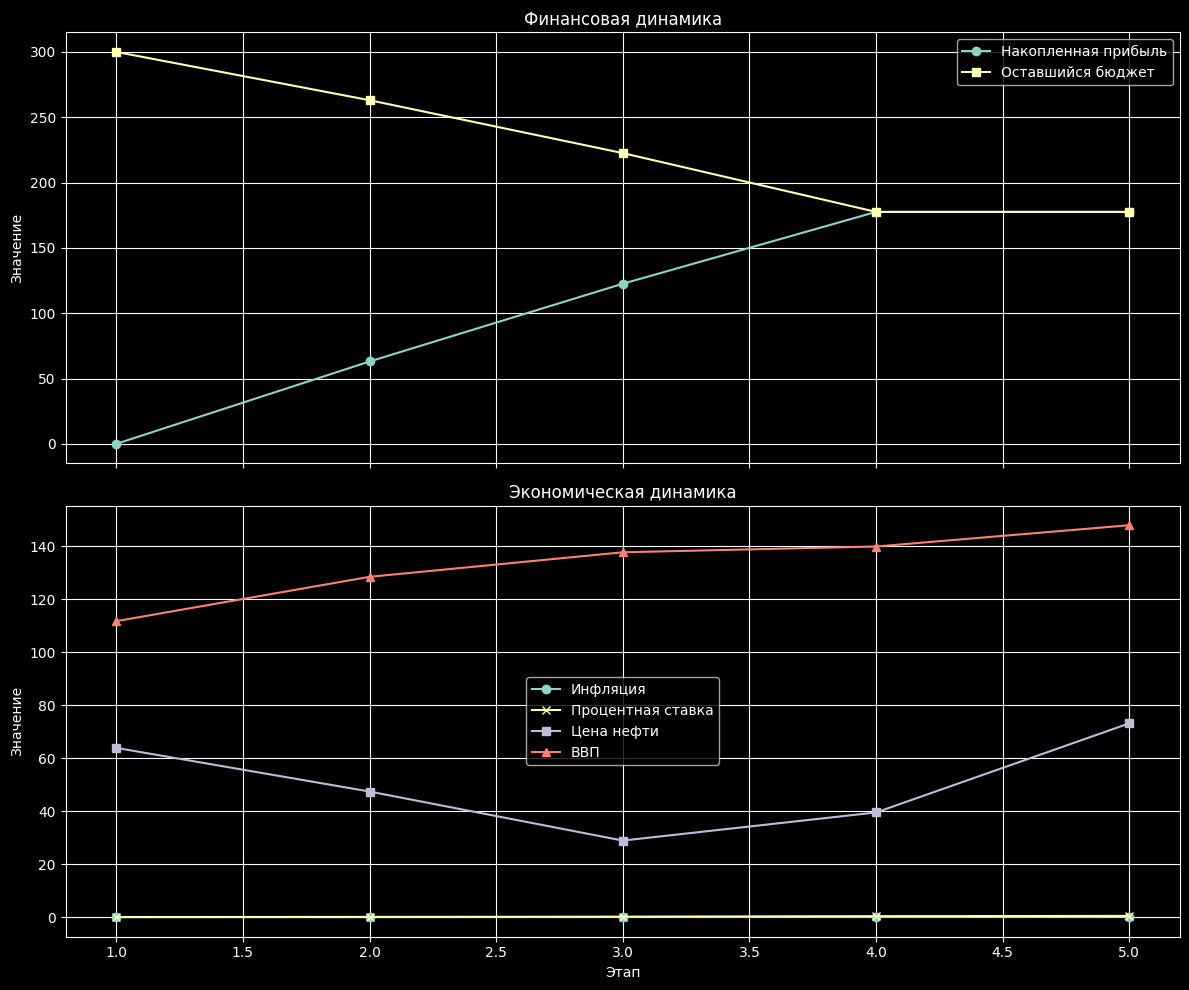

In [199]:
# 1. Определяем глобальную и корпоративную экономику
global_econ = GlobalEconomy(
    gdp=100.0,
    interest_rate=0.05,
    exchange_rate=1.0,
    oil_price=50.0,
    inflation=0.03,
    sanctions=False
)

# 💡 Добавим последовательность шоков и усилим волатильность
shock_sequence = ["neutral", "rate_hike", "oil_crisis", "financial_crisis", "neutral"]
global_econ.oil_price_vol = 0.5
global_econ.exchange_vol = 0.3
global_econ.gdp_growth_vol = 0.05

print("Волатильности:")
print({
    "oil_price_vol": global_econ.oil_price_vol,
    "exchange_vol": global_econ.exchange_vol,
    "gdp_growth_vol": global_econ.gdp_growth_vol
})


company_econ = CompanyEconomy(
    debt=0.0,
    amortization_type='linear',
    accumulated_loss=0.0,
    loan_term=5,
    global_economy=global_econ,
    dividend_percentage=0.05
)


# 2. Задаём начальное состояние
initial_state = State(
    budget=300,
    market_condition="neutral",
    global_econ=global_econ,
    company_econ=company_econ
)

# 3. Проекты
projects = [
    {'levels': [0, 50, 100, 150, 200, 250, 300],
     'profits': [0, 20, 44, 60, 75, 85, 95]},
    {'levels': [0, 50, 100, 150, 200, 250, 300],
     'profits': [0,  5, 51, 70, 80, 90, 100]},
    {'levels': [0, 50, 100, 150, 200, 250, 300],
     'profits': [0, 10, 50, 65, 75, 85, 90]},
    {'levels': [0, 50, 100, 150, 200, 250, 300],
     'profits': [0,  8, 44, 60, 72, 85, 90]},
    {'levels': [0, 50, 100, 150, 200, 250, 300],
     'profits': [0, 16, 39, 55, 76, 92, 99]}
]

# 4. Запуск модели
model = InvestmentModel(projects, step=50, initial_state=initial_state)
max_profit, strategy, states, econ_history = model.optimize()

# 5. Вывод результата
print("Максимальная чистая прибыль:", max_profit)
print("Стратегия распределения инвестиций:")
for i, s in enumerate(strategy, start=1):
    print(f"  Проект {i}: вложить {s:.0f} у.е.")

print("\nИстория состояний:")
for s in states:
    print(f"  Этап {s['step']}: вложено {s['invested']:.0f}, накопленная прибыль {s['profit']:.2f}, остаток бюджета {s['remaining_budget']:.2f}")
InvestmentModel.plot_results(states, econ_history, shock_sequence=model.shock_sequence)